In [2]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.signal import place_poles
from scipy.signal import find_peaks
from scipy.linalg import solve_continuous_are


from plotfunc import plot_sets

In [48]:
R=0.5
L=0.2
C=0.5

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

Q=np.array([[1,0],
            [0,1]])

R=np.array([[1]])

P = solve_continuous_are(A, B, Q, R)

print(f"Macierz P:")
print(P)

Macierz P:
[[1.59270823 0.0472136 ]
 [0.0472136  0.13189887]]


In [6]:
R_inv = np.linalg.inv(R) # Odwrotność macierzy R
K = R_inv @ B.T @ P

print("\nMacierz Wzmocnień K:")
print(K)


Macierz Wzmocnień K:
[[0.09901951 0.66147299]]


In [40]:
def model(x,t):
    R=0.5
    L=0.2
    C=0.5
    u=np.array([[1]])

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])

    dx=A@x+(B*u).flatten()
    return dx

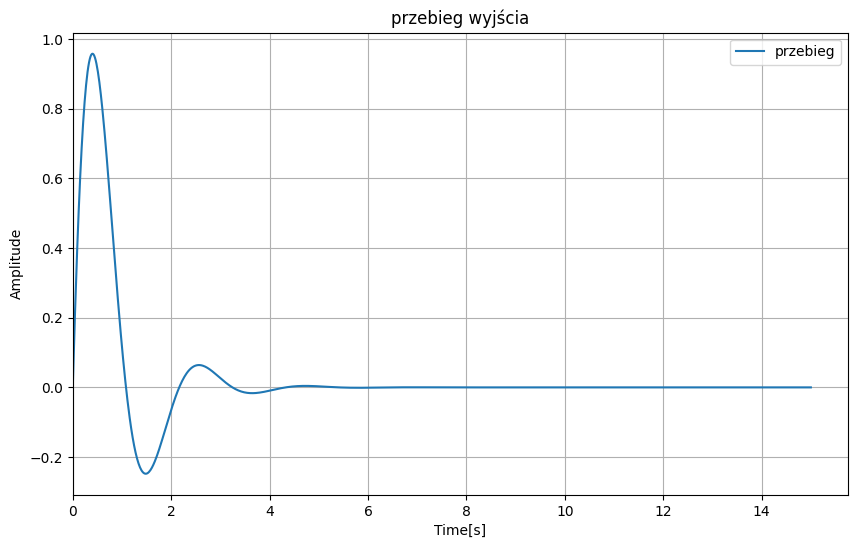

In [41]:
x0 = np.array([0, 0])

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [42]:
def model_with_K(x,t,K):
    R=0.5
    L=0.2
    C=0.5
    u=-K@x

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])
    
    dx=A@x+(B*u).flatten()
    return dx

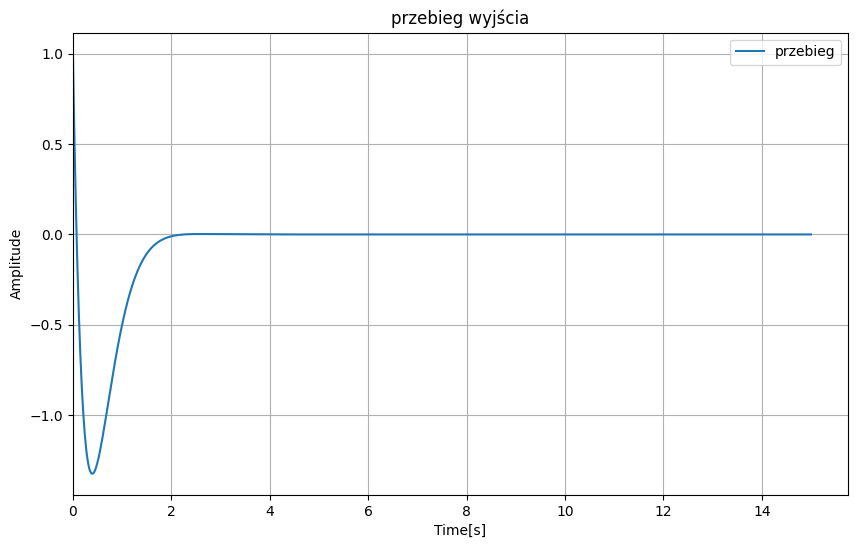

In [43]:
x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x = odeint(model_with_K, x0, t,args=(K,))

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [44]:
R1=np.array([[1]]) #"koszt" energetyczny 
Q1=np.array([[10,0], #"koszt" stanu 
             [0,10]])

P1 = solve_continuous_are(A, B, Q1, R1)
R1_inv = np.linalg.inv(R1) 
K1 = R1_inv @ B.T @ P1

R2=np.array([[10]])
Q2=np.array([[1,0],
             [0,1]])

P2 = solve_continuous_are(A, B, Q2, R2)
R2_inv = np.linalg.inv(R2) 
K2 = R2_inv @ B.T @ P2

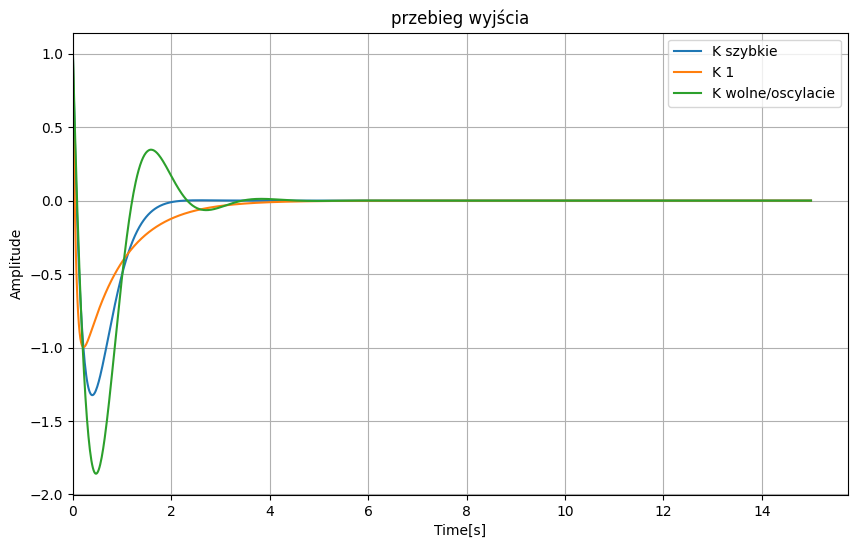

In [45]:

x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x1 = odeint(model_with_K, x0, t,args=(K,))
x2=odeint(model_with_K, x0, t,args=(K1,))
x3=odeint(model_with_K, x0, t,args=(K2,))


y1 = x1[:, 1]
y2 = x2[:, 1]
y3 = x3[:, 1]

plot_sets('przebieg wyjścia',[t,y1,'K szybkie'],
          [t,y2,'K 1'],
          [t,y3,'K wolne/oscylacie'])

In [ ]:
A = np.array([[0.0, 1.0], [-10.0, -2.5]])
B = np.array([[0.0], [5.0]])

def model_cost_function(x_roz, t, K, Q, R_wag):
    """
    Implementacja modelu dynamiki ze sprzężeniem od stanu i integracją 
    wskaźnika jakości J (Zadanie 2.4).
    
    Args:
        x_roz (np.array): Rozszerzony wektor stanu [qc, i, J_akum].
        t (float): Aktualna chwila czasu.
        K (np.array): Macierz wzmocnień regulatora (1x2).
        Q (np.array): Macierz wag stanu (2x2).
        R_wag (np.array): Macierz wag sterowania (1x1).
        
    Returns:
        np.array: Wektor pochodnych stanu [d(qc)/dt, d(i)/dt, d(J_akum)/dt].
    """
    
    # Krok 1: Wydobycie stanu nominalnego (x)
    x = x_roz[:2] 
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu (2x1)

    # Krok 2: Sygnał sterujący (u)
    # u = -Kx (skalar)
    u = -K @ x 
    u_mat = np.array([[u]]) # Macierz 1x1 dla u

    # Krok 3: Obliczenie pochodnych stanu nominalnego (x_dot)
    # x_dot = A@x + B@u
    x_dot_nominal_matrix = A @ x_vec + B @ u_mat
    
    # Krok 4: Obliczenie wyrażenia podcałkowego J_dot
    # J_dot = x^T * Q * x + u^T * R_wag * u
    cost_integrand = x_vec.T @ Q @ x_vec + u_mat.T @ R_wag @ u_mat
    
    # Krok 5: Złożenie wektora pochodnych
    # Konkatenacja wektora pochodnych stanu (2x1) i pochodnej kosztu (1x1)
    # Użycie .flatten() rozwiązuje problem niejednorodnego kształtu
    
    # x_dot_nominal musi być spłaszczony do wektora 1D, aby konkatenacja była poprawna
    x_dot_nominal = x_dot_nominal_matrix.flatten() 
    
    return np.concatenate((x_dot_nominal, cost_integrand.flatten()))

In [54]:
x0 = np.array([1, 1, 0])

t = np.linspace(0, 15, 1000)

R_w=np.array([[1]])

sol_LQR = odeint(model_cost_function, x0, t, args=(K, Q, R_w))
J_LQR = sol_LQR[-1, 2] # Wartość J_akum w ostatniej chwili

# Symulacja dla innych wzmocnień (nieoptymalne)
sol_Inne = odeint(model_cost_function, x0, t, args=(K1, Q1, R1))
J_Inne = sol_Inne[-1, 2]

print(f"Wartość wskaźnika J dla wzmocnień LQR: {J_LQR:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne:.4f}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.